numerical:
[[ 0.    1.  ]
 [ 0.   -0.15]]
[[0.]
 [3.]]
true:
[[ 0.    1.  ]
 [ 0.   -0.15]]
[[0.]
 [3.]]


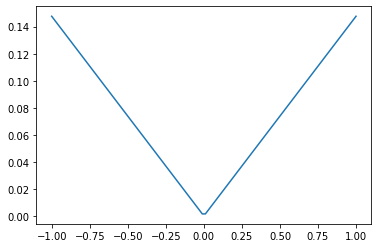

In [76]:
import scipy
from scipy.interpolate import CubicHermiteSpline, PPoly, interp1d
from scipy.integrate import solve_ivp, ode, odeint
import jax
import pickle
import numpy as np
import matplotlib.pyplot as plt

def dynamics(x, u):
    MIN_ANGLE, MAX_ANGLE = -np.pi, np.pi
    MIN_W, MAX_W = -7., 7

    MIN_TORQUE, MAX_TORQUE = -1., 1.

    LENGTH = 1.
    MASS = 1.
    DAMPING = .05
    gravity_coeff = MASS*9.81*LENGTH*0.5
    integration_coeff = 3. / (MASS*LENGTH*LENGTH)
    res = np.zeros(2)
    res[0] = x[1]
    res[1] = integration_coeff * (u[0] - gravity_coeff*np.cos(x[0]) - DAMPING*x[1])
    if res[0] < -np.pi:
        res[0] += 2*np.pi
    elif res[0] > np.pi:
        res[0] -= 2 * np.pi
    res = np.clip(res, [MIN_ANGLE, MIN_W], [MAX_ANGLE, MAX_W])
    return res


def jax_dynamics(x, u):
    MIN_ANGLE, MAX_ANGLE = -np.pi, np.pi
    MIN_W, MAX_W = -7., 7

    MIN_TORQUE, MAX_TORQUE = -1., 1.

    LENGTH = 1.
    MASS = 1.
    DAMPING = .05
    gravity_coeff = MASS*9.81*LENGTH*0.5
    integration_coeff = 3. / (MASS*LENGTH*LENGTH)
    #res = jax.numpy.zeros(2)
    #res[0] = x[1]
    #res[1] = integration_coeff * (u[0] - gravity_coeff*jax.numpy.cos(x[0]) - DAMPING*x[1])
    return jax.numpy.asarray([x[1],integration_coeff * (u[0] - gravity_coeff*jax.numpy.cos(x[0]) - DAMPING*x[1])])

def true_linear(x, u):
    MIN_ANGLE, MAX_ANGLE = -np.pi, np.pi
    MIN_W, MAX_W = -7., 7

    MIN_TORQUE, MAX_TORQUE = -1., 1.

    LENGTH = 1.
    MASS = 1.
    DAMPING = .05
    gravity_coeff = MASS*9.81*LENGTH*0.5
    integration_coeff = 3. / (MASS*LENGTH*LENGTH)
    A = np.zeros((2,2))
    A[0,0] = 0
    A[0,1] = 1.
    A[1,0] = integration_coeff*gravity_coeff*np.sin(x[0])
    A[1,1] = -integration_coeff*DAMPING
    B = np.zeros((2,1))
    B[0,0] = 0
    B[1,0] = integration_coeff
    return A,B
 


def jaxfunc(x, u):
    return jax.numpy.asarray(jax_dynamics(x, u))

def linearization(x, u):
    A = jax.jacfwd(jaxfunc, argnums=0)(x, u)
    B = jax.jacfwd(jaxfunc, argnums=1)(x, u)
    return A, B
    
# read the data obtained from sparse_rrt
f = open('../../data/pendulum/path_0.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
x = p.load()
f = open('../../data/pendulum/control_0.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
u = p.load()
u = u.reshape(len(u),1)
f = open('../../data/pendulum/cost_0.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
dt = p.load()

# see if the linearization is working fine
direction = np.random.normal(size=3)
direction = direction / np.linalg.norm(direction)
epsilon = np.linspace(-1, 1, 100)

x = x[2]
#u = np.array([u[5]])
u = u[2]
x = np.array([0.,0.])
u = np.array([0.])
state = np.array([x[0], x[1], u[0]])
# linearlize around this point
approx_error = []
for i in range(len(epsilon)):
    new_state = direction * epsilon[i] + state
    new_x = new_state[:2]
    new_u = np.array([new_state[2]])
    true_dx = dynamics(new_x, new_u)
    A, B = linearization(x, u)
    approx_dx = dynamics(x, u) + A @ (new_x - x) + B @ (new_u - u)
    approx_error.append(np.linalg.norm(approx_dx - true_dx))
plt.plot(epsilon, approx_error)


true_A, true_B = true_linear(x, u)
print('numerical:')
print(A)
print(B)
print('true:')
print(true_A)
print(true_B)


In [77]:
# plotting the lyapunov verification region
from python_lyapunov import *
# read the data obtained from sparse_rrt

f = open('../../data/pendulum_lyapunov/0/path_1.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
x = p.load()
f = open('../../data/pendulum_lyapunov/0/control_1.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
u = p.load()
u = u.reshape(len(u),1)
f = open('../../data/pendulum_lyapunov/0/cost_1.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
dt = p.load()
f = open('../../data/pendulum_lyapunov/0/start_goal_1.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
sg = p.load()
goal = sg[-1]
"""
# cartpole
f = open('../../data/cartpole/0/path_1.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
x = p.load()
f = open('../../data/cartpole/0/control_1.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
u = p.load()
u = u.reshape(len(u),1)
f = open('../../data/cartpole/0/cost_1.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
dt = p.load()
goal = x[-1]
#goal = sg[-1]
"""


new_x = []
new_u = []
new_dt = []
new_x0 = x[0]
new_x.append(new_x0)
# what if we only look at the first segment

x0 = x[0]
xT = x[-1]
print('previous xT:')
print(xT)

MIN_ANGLE, MAX_ANGLE = -np.pi, np.pi
MIN_W, MAX_W = -7., 7

MIN_TORQUE, MAX_TORQUE = -1., 1.

LENGTH = 1.
MASS = 1.
DAMPING = .05
gravity_coeff = MASS*9.81*LENGTH*0.5
integration_coeff = 3. / (MASS*LENGTH*LENGTH)

for i in range(len(dt)):
    for j in range(int(dt[i]/0.002)):
        new_x0 = new_x0 + 0.002*dynamics(new_x0, u[i])
        if new_x0[0] < -np.pi:
            new_x0[0] += 2*np.pi
        if new_x0[0] > np.pi:
            new_x0[0] -= 2*np.pi
        new_x0 = np.clip(new_x0, [MIN_ANGLE, MIN_W], [MAX_ANGLE, MAX_W])
        #new_x.append(new_x0)
        #new_u.append(u[i])
        #new_dt.append(0.002)
    new_x.append(new_x0)
    new_u.append(u[i])
    new_dt.append(dt[i])
x = new_x
u = new_u
dt = new_dt

time_knot = np.cumsum(new_dt)
time_knot = np.insert(time_knot, 0, 0.)
print(time_knot)
# obtain a lqr for end position
#A = jax.jacfwd(jaxfunc, argnums=0)(xtraj(time_knot[-1]), utraj(time_knot[-1]))
#B = jax.jacfwd(jaxfunc, argnums=1)(xtraj(time_knot[-1]), utraj(time_knot[-1]))

controller, xtraj, utraj, S = tvlqr(x, u, dt, dynamics, jax_dynamics)


previous xT:
[-2.38021529  0.00576279]
[0.    0.05  0.22  0.316 0.588 0.788 0.982 1.352]
[1. 0. 0. 1.]


In [78]:
print(x)
x = np.array(x)

[array([-1.98454638,  3.80707763]), array([-1.78693486,  4.08523156]), array([-1.1130414 ,  3.56115635]), array([-0.82061077,  2.45399074]), array([-0.56504916, -0.68156727]), array([-0.92686071, -2.83012884]), array([-1.5854249 , -3.66790824]), array([-2.38021529,  0.00576279])]


[[-1.98454638  3.80707763]
 [-1.95881053  3.85357746]
 [-1.93276035  3.89768415]
 [-1.90641201  3.93939327]
 [-1.87978171  3.97867122]
 [-1.85288589  4.01545522]
 [-1.82574141  4.04965337]
 [-1.79836576  4.08114456]
 [-1.77077722  4.10977832]
 [-1.74299512  4.1203159 ]
 [-1.71514178  4.12812468]
 [-1.68723566  4.13320293]
 [-1.65929521  4.13555106]
 [-1.63133888  4.13517154]
 [-1.60338512  4.13206893]
 [-1.57545234  4.12624972]
 [-1.54755889  4.11772232]
 [-1.51972309  4.10649688]
 [-1.49196317  4.09258517]
 [-1.46429729  4.07600044]
 [-1.43674353  4.05675726]
 [-1.40931985  4.03487129]
 [-1.38204412  4.01035915]
 [-1.35493409  3.98323814]
 [-1.3280074   3.95352611]
 [-1.30128156  3.92124115]
 [-1.27477397  3.88640142]
 [-1.2485019   3.84902492]
 [-1.22248249  3.80912922]
 [-1.19673278  3.76673128]
 [-1.17126968  3.72184722]
 [-1.14610999  3.67449206]
 [-1.12127042  3.62467959]
 [-1.09676759  3.57242209]
 [-1.07261801  3.50434275]
 [-1.04892866  3.43415146]
 [-1.02571379  3.36187303]
 

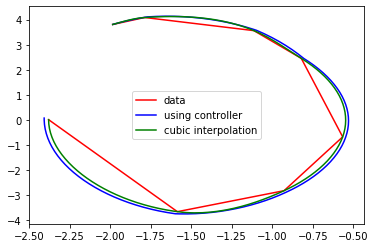

In [79]:
plt.plot(x[:,0], x[:,1], 'r', label='data')

num = 200
time_span = np.linspace(0, np.sum(dt), num+1)
delta_t = time_span[-1] / num
actual_x = np.array(x0)
xs = []
xs.append(actual_x)
real_xs = []
# plot data
for i in range(len(time_span)):
    u = controller(time_span[i], actual_x)
    #print('current state:')
    #print(x)
    #print('tracked traj:')
    #print(x_traj(time_span[i]))
    xdot = dynamics(actual_x, u)
    actual_x = actual_x + xdot * delta_t
    xs.append(actual_x)
    real_xs.append(xtraj(time_span[i]))
    if actual_x[0] < -np.pi:
        actual_x[0] = actual_x[0] + 2*np.pi
    if actual_x[0] > np.pi:
        actual_x[0] = actual_x[0] - 2*np.pi
    actual_x = np.clip(actual_x, [MIN_ANGLE, MIN_W], [MAX_ANGLE, MAX_W])
xs = np.array(xs)
real_xs = np.array(real_xs)
print(xs)
print(real_xs)
plt.plot(xs[:,0], xs[:,1], 'b', label='using controller')
plt.plot(real_xs[:,0], real_xs[:,1], 'g', label='cubic interpolation')
plt.legend()

In [80]:
xG = np.array(goal)
uG = stable_u(xG)
print(dynamics(xG, uG))
A = jax.jacfwd(jaxfunc, argnums=0)(xG, uG)
B = jax.jacfwd(jaxfunc, argnums=1)(xG, uG)

A = np.asarray(A)
B = np.asarray(B)
Q = np.identity(2)
R = np.identity(1)
K, lqr_S, E = control.lqr(A, B, Q, R)

#print(dynamics(xtraj(time_knot[-1]), utraj(time_knot[-1])))
lqr_rho = sample_ti_verify(xG, uG, lqr_S, K, dynamics, numSample=1000)
# create a funnel that guides
upper_rho = lqr_rho
upper_x = xG
upper_S = lqr_S

tvlqr_rhos = []
print(len(time_knot))

for i in range(len(time_knot)-1,0,-1):
    print('knot %d' % (i))
    t0 = time_knot[i-1]
    t1 = time_knot[i]
    x0 = xtraj(t0)
    u0 = utraj(t0)
    x1 = xtraj(t1)
    u1 = utraj(t1)
    A0 = jax.jacfwd(jaxfunc, argnums=0)(x0, u0)
    B0 = jax.jacfwd(jaxfunc, argnums=1)(x0, u0)
    A1 = jax.jacfwd(jaxfunc, argnums=0)(x1, u1)
    B1 = jax.jacfwd(jaxfunc, argnums=1)(x1, u1)
    A0 = np.asarray(A0)
    B0 = np.asarray(B0)
    A1 = np.asarray(A1)
    B1 = np.asarray(B1)

    S0 = S(t0).reshape(len(x0),len(x0))
    S1 = S(t1).reshape(len(x0),len(x0))

    rho0, rho1 = sample_tv_verify(t0, t1, upper_x, upper_S, upper_rho, S0, S1, A0, A1, B0, B1, R, Q, x0, x1, u0, u1, dynamics, numSample=1000)
    upper_rho = rho0
    upper_x = x0
    upper_S = S0
    tvlqr_rhos.append([rho0, rho1, t0, t1])
    
    


[0. 0.]
rho: 
0.001
rho: 
0.0011
rho: 
0.0012100000000000001
rho: 
0.0013310000000000002
rho: 
0.0014641000000000003
rho: 
0.0016105100000000005
rho: 
0.0017715610000000007
rho: 
0.0019487171000000009
rho: 
0.002143588810000001
rho: 
0.0023579476910000016
rho: 
0.002593742460100002
rho: 
0.0028531167061100022
rho: 
0.003138428376721003
rho: 
0.0034522712143931033
rho: 
0.003797498335832414
rho: 
0.004177248169415656
rho: 
0.004594972986357222
rho: 
0.005054470284992944
rho: 
0.005559917313492239
rho: 
0.006115909044841464
rho: 
0.006727499949325611
rho: 
0.007400249944258173
rho: 
0.008140274938683991
rho: 
0.00895430243255239
rho: 
0.00984973267580763
rho: 
0.010834705943388393
rho: 
0.011918176537727233
rho: 
0.013109994191499958
rho: 
0.014420993610649954
rho: 
0.01586309297171495
rho: 
0.017449402268886447
rho: 
0.019194342495775094
rho: 
0.021113776745352607
rho: 
0.02322515441988787
rho: 
0.02554766986187666
rho: 
0.02810243684806433
rho: 
0.030912680532870763
rho: 
0.03400394858

In [81]:
print(time_knot)
print(xtraj(0))
print(x[0])

[0.    0.05  0.22  0.316 0.588 0.788 0.982 1.352]
[-1.98454638  3.80707763]
[-1.98454638  3.80707763]


0.982
1.023111111111111
1.0642222222222222
1.1053333333333333
1.1464444444444444
1.1875555555555555
1.2286666666666666
1.2697777777777777
1.3108888888888888
1.3519999999999999
0.788
0.8095555555555556
0.8311111111111111
0.8526666666666667
0.8742222222222222
0.8957777777777778
0.9173333333333333
0.9388888888888889
0.9604444444444444
0.982
0.5880000000000001
0.6102222222222223
0.6324444444444445
0.6546666666666667
0.676888888888889
0.6991111111111111
0.7213333333333334
0.7435555555555555
0.7657777777777778
0.788
0.31600000000000006
0.34622222222222226
0.3764444444444445
0.40666666666666673
0.43688888888888894
0.46711111111111114
0.4973333333333334
0.5275555555555556
0.5577777777777778
0.5880000000000001
0.22000000000000003
0.2306666666666667
0.24133333333333337
0.25200000000000006
0.2626666666666667
0.2733333333333334
0.28400000000000003
0.29466666666666674
0.3053333333333334
0.31600000000000006
0.05
0.06888888888888889
0.08777777777777779
0.10666666666666669
0.1255555555555556
0.1444444

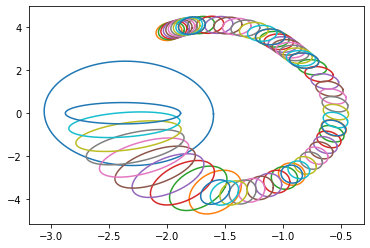

In [82]:
# plot lqr_rho
# sampling points in the epplisolid (x-xG)TS(x-xG)=rho

def plot_ellipsoid(S, rho, x0):
    theta = np.linspace(0, np.pi*2, 100)
    U = [np.cos(theta), np.sin(theta)]
    U = np.array(U).T
    tmp = np.linalg.pinv(S)
    tmp = scipy.linalg.sqrtm(tmp.T @ tmp)
    S_invsqrt = scipy.linalg.sqrtm(tmp)
    X = U @ S_invsqrt  # 100x2
    X = rho*X + x0
    plt.plot(X[:,0],X[:,1])

plot_ellipsoid(lqr_S, lqr_rho, xG)
    
# plot funnel
# rho_t = rho0+(rho1-rho0)/(t1-t0)*t
for j in range(len(tvlqr_rhos)):
    rho0, rho1, t0, t1 = tvlqr_rhos[j]
    plot_ts = np.linspace(t0, t1, 10)
    rho_ts = rho0+(rho1-rho0)/(t1-t0)*(plot_ts-t0)
    for i in range(len(rho_ts)):
        rho_t = rho_ts[i]
        plot_t = plot_ts[i]
        print(plot_t)
        S_t = S(plot_t).reshape(len(x0),len(x0))
        x_t = xtraj(plot_t)
        u_t = utraj(plot_t)
        # plot
        plot_ellipsoid(S_t, rho_t, x_t)



t0:
0.0
0-th sample
num: 67
1-th sample
num: 67
2-th sample
num: 67
3-th sample
num: 67
4-th sample
num: 67
5-th sample
num: 67
6-th sample
num: 67
7-th sample
num: 67
8-th sample
num: 67
9-th sample
num: 67
10-th sample
num: 67
11-th sample
num: 67
12-th sample
num: 67
13-th sample
num: 67
14-th sample
num: 67
15-th sample
num: 67
16-th sample
num: 67
17-th sample
num: 67
18-th sample
num: 67
19-th sample
num: 67
20-th sample
num: 67
21-th sample
num: 67
22-th sample
num: 67
23-th sample
num: 67
24-th sample
num: 67
25-th sample
num: 67
26-th sample
num: 67
27-th sample
num: 67
28-th sample
num: 67
29-th sample
num: 67
30-th sample
num: 67
31-th sample
num: 67
32-th sample
num: 67
33-th sample
num: 67
34-th sample
num: 67
35-th sample
num: 67
36-th sample
num: 67
37-th sample
num: 67
38-th sample
num: 67
39-th sample
num: 67
40-th sample
num: 67
41-th sample
num: 67
42-th sample
num: 67
43-th sample
num: 67
44-th sample
num: 67
45-th sample
num: 67
46-th sample
num: 67
47-th sample
nu

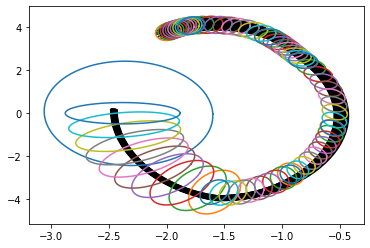

In [83]:

# here we test by randomly sample different pertubation to the starting point to see if tvlqr is working
rho0, rho1, t0, t1 = tvlqr_rhos[-1]
print('t0:')
print(t0)
S0 = S(0.).reshape(len(x[0]),len(x[0]))
numSample = 100
U = np.random.normal(loc=0.0, scale=1.0, size=(numSample,len(S0)))
# individually normalize each sample
U = U / np.linalg.norm(U, axis=1, keepdims=True)
for i in range(len(U)):
    alpha = np.random.uniform()
    U[i] = U[i] * alpha
tmp = np.linalg.pinv(S0)
tmp = scipy.linalg.sqrtm(tmp.T @ tmp)
U0 = U@scipy.linalg.sqrtm(tmp)
X0 = rho0*U0 + x[0] # 100x2

for k in range(numSample):
    print('%d-th sample' % (k))
    num = np.sum(dt)/0.02
    print('num: %d' % (num))
    time_span = np.linspace(0, np.sum(dt), num+1)
    delta_t = time_span[-1] / num
    actual_x = np.array(X0[k])
    xs = []
    xs.append(actual_x)
    # plot data
    for i in range(len(time_span)):
        u = controller(time_span[i], actual_x)
        #print('current state:')
        #print(x)
        #print('tracked traj:')
        #print(x_traj(time_span[i]))
        xdot = dynamics(actual_x, u)
        actual_x = actual_x + xdot * delta_t
        xs.append(actual_x)
        if actual_x[0] < -np.pi:
            actual_x[0] = actual_x[0] + 2*np.pi
        if actual_x[0] > np.pi:
            actual_x[0] = actual_x[0] - 2*np.pi
        actual_x = np.clip(actual_x, [MIN_ANGLE, MIN_W], [MAX_ANGLE, MAX_W])
    xs = np.array(xs)
    #print(xs)
    #print(real_xs)
    plt.plot(xs[:,0], xs[:,1], 'black', label='using controller')

plot_ellipsoid(lqr_S, lqr_rho, xG)
    
# plot funnel
# rho_t = rho0+(rho1-rho0)/(t1-t0)*t
for j in range(len(tvlqr_rhos)):
    rho0, rho1, t0, t1 = tvlqr_rhos[j]
    plot_ts = np.linspace(t0, t1, 10)
    rho_ts = rho0+(rho1-rho0)/(t1-t0)*(plot_ts-t0)
    for i in range(len(rho_ts)):
        rho_t = rho_ts[i]
        plot_t = plot_ts[i]
        S_t = S(plot_t).reshape(len(x0),len(x0))
        x_t = xtraj(plot_t)
        u_t = utraj(plot_t)
        # plot
        plot_ellipsoid(S_t, rho_t, x_t)

